In [2]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# IMPORT IMDB & BASIC CLEAN UP

In [3]:
# connect IMDB

con =sqlite3.connect('zippedData/im.db')

In [4]:
# IMDB select columns from movie_basics
# primary_name,original_title,genres,averagerating,numvotes
# order by primary_title

df_IMDB = pd.read_sql("""
SELECT b.primary_title,b.original_title,b.genres AS IMDB_genres,r.averagerating AS IMDB_ratings,r.numvotes AS IMDB_nvotes
FROM movie_ratings AS r
LEFT JOIN movie_basics AS b
ON r.movie_id = b.movie_id
ORDER BY b.primary_title
""",con)
df_IMDB.head()

,primary_title,original_title,IMDB_genres,IMDB_ratings,IMDB_nvotes
0,!Women Art Revolution,Women Art Revolution,Documentary,6.9,196
1,#1 Serial Killer,#1 Serial Killer,Horror,5.6,40
2,#5,#5,"Biography,Comedy,Fantasy",6.8,6
3,#66,#66,Action,5.3,18
4,#ALLMYMOVIES,#ALLMYMOVIES,Documentary,8.3,21


In [5]:
df_IMDB.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73856 entries, 0 to 73855
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   primary_title   73856 non-null  object 
 1   original_title  73856 non-null  object 
 2   IMDB_genres     73052 non-null  object 
 3   IMDB_ratings    73856 non-null  float64
 4   IMDB_nvotes     73856 non-null  int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 2.8+ MB


In [6]:
df_IMDB.describe()

,IMDB_ratings,IMDB_nvotes
count,73856.000000,7.385600e+04
mean,6.332729,3.523662e+03
std,1.474978,3.029402e+04
min,1.000000,5.000000e+00
25%,5.500000,1.400000e+01
50%,6.500000,4.900000e+01
75%,7.400000,2.820000e+02
max,10.000000,1.841066e+06


In [7]:
df_IMDB = df_IMDB.dropna()

In [8]:
df_IMDB.isna().sum()

primary_title     0
original_title    0
IMDB_genres       0
IMDB_ratings      0
IMDB_nvotes       0
dtype: int64

In [9]:
# check the outliers

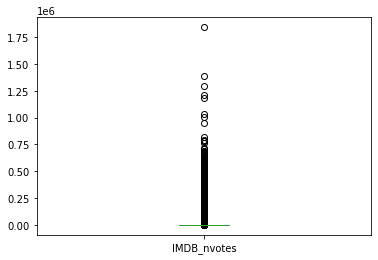

In [10]:
df_IMDB['IMDB_nvotes'].plot(kind='box');
# very skewed, some
# needs to trim

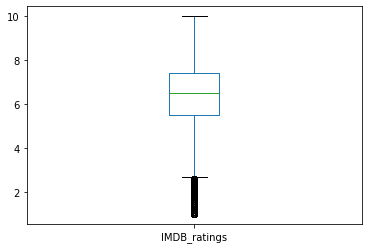

In [11]:
df_IMDB['IMDB_ratings'].plot(kind='box');
# skewed, but bad movie maybe not mean bad profit?

In [12]:
# which movie has the best rating

<AxesSubplot:ylabel='Frequency'>

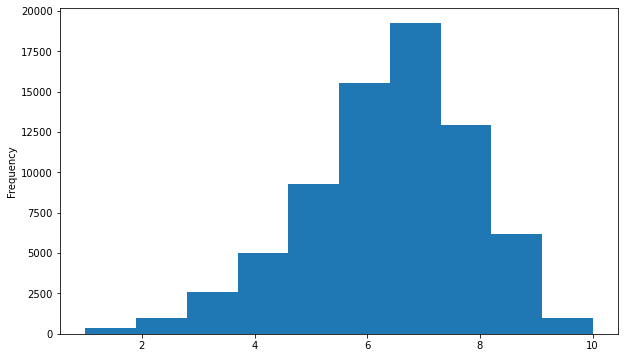

In [13]:
# check overall movie ratings
df_IMDB['IMDB_ratings'].plot(kind='hist',bins=10,figsize=(10,6))
# 6.9 is the median

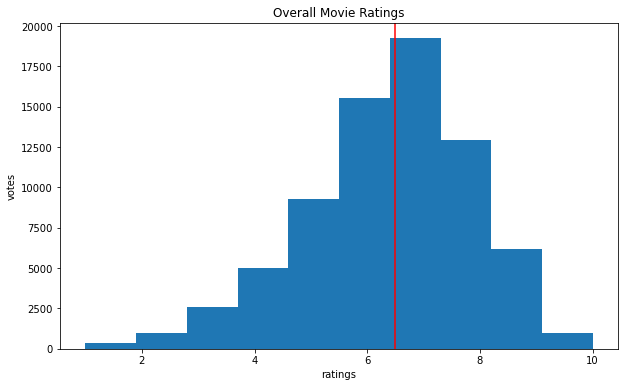

In [14]:
fig,ax = plt.subplots(figsize=(10,6))
ax.hist(df_IMDB['IMDB_ratings'],bins=10)
ax.axvline(df_IMDB['IMDB_ratings'].median(),c='r')
# median is 6.9
ax.set_title('Overall Movie Ratings')
ax.set_xlabel('ratings')
ax.set_ylabel('votes');

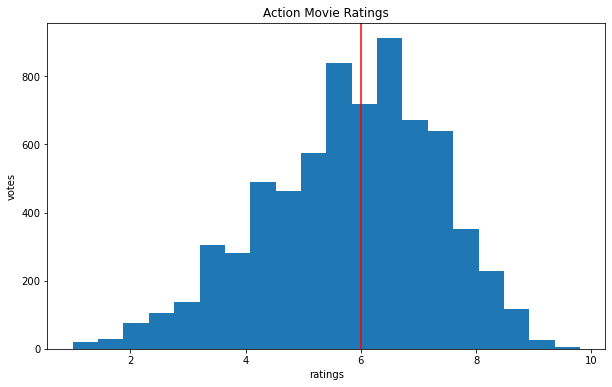

In [15]:
fig,ax = plt.subplots(figsize=(10,6))
ax.hist(df_IMDB[df_IMDB['IMDB_genres'].str.contains('Action')]['IMDB_ratings'],bins=20)
ax.axvline(df_IMDB[df_IMDB['IMDB_genres'].str.contains('Action')]['IMDB_ratings'].median(),c='r')
ax.set_title('Action Movie Ratings')
ax.set_xlabel('ratings')
ax.set_ylabel('votes');

In [16]:
df_IMDB[df_IMDB['IMDB_genres'].str.contains('Action')]['IMDB_ratings'].median()

6.0

<AxesSubplot:ylabel='Frequency'>

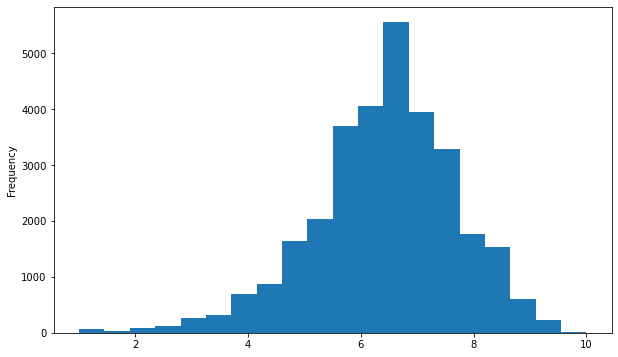

In [17]:
# Drama movie overall ratings
df_IMDB[df_IMDB['IMDB_genres'].str.contains('Drama')]['IMDB_ratings'].plot(kind='hist',bins=20,figsize=(10,6))

create a df of genres and its ratings
best rating and median ratings

but first use TM to filter the IMDB
IMDB has many not commercial movie info

# IMPORT TM & MERGE WITH IMDB

In [18]:
# get TM movies CSV
# start to clean it
# use it to filter IMDB

df_tm_movies = pd.read_csv('zippedData/tmdb.movies.csv')
df_tm_movies

,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610
2,2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368
3,3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174
4,4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186
...,...,...,...,...,...,...,...,...,...,...
26512,26512,"[27, 18]",488143,en,Laboratory Conditions,0.600,2018-10-13,Laboratory Conditions,0.0,1
26513,26513,"[18, 53]",485975,en,_EXHIBIT_84xxx_,0.600,2018-05-01,_EXHIBIT_84xxx_,0.0,1
26514,26514,"[14, 28, 12]",381231,en,The Last One,0.600,2018-10-01,The Last One,0.0,1
26515,26515,"[10751, 12, 28]",366854,en,Trailer Made,0.600,2018-06-22,Trailer Made,0.0,1


In [19]:
df_tm_movies_clean = df_tm_movies[['title','original_title','release_date','vote_average','vote_count']]
df_tm_movies_clean

,title,original_title,release_date,vote_average,vote_count
0,Harry Potter and the Deathly Hallows: Part 1,Harry Potter and the Deathly Hallows: Part 1,2010-11-19,7.7,10788
1,How to Train Your Dragon,How to Train Your Dragon,2010-03-26,7.7,7610
2,Iron Man 2,Iron Man 2,2010-05-07,6.8,12368
3,Toy Story,Toy Story,1995-11-22,7.9,10174
4,Inception,Inception,2010-07-16,8.3,22186
...,...,...,...,...,...
26512,Laboratory Conditions,Laboratory Conditions,2018-10-13,0.0,1
26513,_EXHIBIT_84xxx_,_EXHIBIT_84xxx_,2018-05-01,0.0,1
26514,The Last One,The Last One,2018-10-01,0.0,1
26515,Trailer Made,Trailer Made,2018-06-22,0.0,1


In [20]:
# join IMDB with TM

df_join = pd.merge(df_IMDB,df_tm_movies_clean,how='inner',left_on='primary_title',right_on='title')

In [21]:
df_join

,primary_title,original_title_x,IMDB_genres,IMDB_ratings,IMDB_nvotes,title,original_title_y,release_date,vote_average,vote_count
0,#ALLMYMOVIES,#ALLMYMOVIES,Documentary,8.3,21,#ALLMYMOVIES,#ALLMYMOVIES,2015-11-12,9.0,4
1,#Captured,#Captured,Thriller,2.8,212,#Captured,#Captured,2017-10-11,3.2,6
2,#FollowFriday,#FollowFriday,Thriller,2.8,186,#FollowFriday,#FollowFriday,2016-07-01,3.2,7
3,#Horror,#Horror,"Crime,Drama,Horror",3.0,3092,#Horror,#Horror,2015-11-20,3.3,102
4,#Lucky Number,#Lucky Number,Comedy,5.1,425,#Lucky Number,#Lucky Number,2015-09-01,6.0,2
...,...,...,...,...,...,...,...,...,...,...
19874,i hate myself :),i hate myself :),"Comedy,Documentary,Drama",7.7,46,i hate myself :),i hate myself :),2013-07-19,8.0,1
19875,iGirlfriend,iGirlfriend,Comedy,2.7,200,iGirlfriend,iGirlfriend,2017-01-15,4.0,4
19876,iSteve,iSteve,"Biography,Comedy",5.3,1098,iSteve,iSteve,2013-04-14,4.8,22
19877,xXx: Return of Xander Cage,xXx: Return of Xander Cage,"Action,Adventure,Thriller",5.2,77976,xXx: Return of Xander Cage,xXx: Return of Xander Cage,2017-01-20,5.6,2452


In [22]:
df_join_clean = df_join.drop(columns=['title','original_title_y'])

In [23]:
df_join_clean = df_join_clean.drop_duplicates()

In [24]:
df_join_clean['release_date'] = pd.to_datetime(df_join_clean['release_date'])

In [29]:
df_join_clean['IMDB_genres'].astype('category')

0                      Documentary
1                         Thriller
2                         Thriller
3               Crime,Drama,Horror
4                           Comedy
                   ...            
19874     Comedy,Documentary,Drama
19875                       Comedy
19876             Biography,Comedy
19877    Action,Adventure,Thriller
19878                  Documentary
Name: IMDB_genres, Length: 18830, dtype: category
Categories (617, object): ['Action', 'Action,Adventure', 'Action,Adventure,Animation', 'Action,Adventure,Biography', ..., 'Thriller,War', 'Thriller,Western', 'War', 'Western']

In [30]:
df_join_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18830 entries, 0 to 19878
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   primary_title     18830 non-null  object        
 1   original_title_x  18830 non-null  object        
 2   IMDB_genres       18830 non-null  object        
 3   IMDB_ratings      18830 non-null  float64       
 4   IMDB_nvotes       18830 non-null  int64         
 5   release_date      18830 non-null  datetime64[ns]
 6   vote_average      18830 non-null  float64       
 7   vote_count        18830 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(2), object(3)
memory usage: 1.3+ MB


In [31]:
df_join_clean.describe()

,IMDB_ratings,IMDB_nvotes,vote_average,vote_count
count,18830.000000,1.883000e+04,18830.000000,18830.000000
mean,5.915157,1.364132e+04,5.770664,266.307807
std,1.399405,6.003093e+04,1.713190,1113.087212
min,1.100000,5.000000e+00,0.000000,1.000000
25%,5.000000,8.400000e+01,4.900000,2.000000
50%,6.100000,3.860000e+02,6.000000,8.000000
75%,6.900000,2.538000e+03,6.900000,53.000000
max,9.800000,1.841066e+06,10.000000,22186.000000


In [32]:
df_join_clean

,primary_title,original_title_x,IMDB_genres,IMDB_ratings,IMDB_nvotes,release_date,vote_average,vote_count
0,#ALLMYMOVIES,#ALLMYMOVIES,Documentary,8.3,21,2015-11-12,9.0,4
1,#Captured,#Captured,Thriller,2.8,212,2017-10-11,3.2,6
2,#FollowFriday,#FollowFriday,Thriller,2.8,186,2016-07-01,3.2,7
3,#Horror,#Horror,"Crime,Drama,Horror",3.0,3092,2015-11-20,3.3,102
4,#Lucky Number,#Lucky Number,Comedy,5.1,425,2015-09-01,6.0,2
...,...,...,...,...,...,...,...,...
19874,i hate myself :),i hate myself :),"Comedy,Documentary,Drama",7.7,46,2013-07-19,8.0,1
19875,iGirlfriend,iGirlfriend,Comedy,2.7,200,2017-01-15,4.0,4
19876,iSteve,iSteve,"Biography,Comedy",5.3,1098,2013-04-14,4.8,22
19877,xXx: Return of Xander Cage,xXx: Return of Xander Cage,"Action,Adventure,Thriller",5.2,77976,2017-01-20,5.6,2452


# EDA WITH THE GENRES

In [45]:
# get a df for genre & ratings from IMDB

df_IMDB_genre_ratings = df_join_clean[['primary_title','IMDB_genres','IMDB_ratings','IMDB_nvotes']]

In [46]:
df_IMDB_genre_ratings.head()

,primary_title,IMDB_genres,IMDB_ratings,IMDB_nvotes
0,#ALLMYMOVIES,Documentary,8.3,21
1,#Captured,Thriller,2.8,212
2,#FollowFriday,Thriller,2.8,186
3,#Horror,"Crime,Drama,Horror",3.0,3092
4,#Lucky Number,Comedy,5.1,425


In [49]:
df_IMDB_genre_ratings.columns = ['title', 'genres', 'ratings', 'nvotes']

In [57]:
df_IMDB_genre_ratings = df_IMDB_genre_ratings.sort_values(by=['genres','ratings'],ascending=True)
df_IMDB_genre_ratings.head()

,title,genres,ratings,nvotes
18885,VS: The Movie,Action,2.1,68
8907,King Arthur and the Knights of the Round Table,Action,2.2,471
10556,Monster Island,Action,2.5,111
18871,Urgency,Action,2.6,207
8171,In the Name of Ben Hur,Action,2.7,737


In [47]:
df_IMDB_genre_ratings.describe()

,IMDB_ratings,IMDB_nvotes
count,18830.000000,1.883000e+04
mean,5.915157,1.364132e+04
std,1.399405,6.003093e+04
min,1.100000,5.000000e+00
25%,5.000000,8.400000e+01
50%,6.100000,3.860000e+02
75%,6.900000,2.538000e+03
max,9.800000,1.841066e+06


In [27]:
# find unique genres
unique_genres = []

for g in df_join_clean['IMDB_genres']:
    temp = g.split(',')
    for t in temp:
        if t not in unique_genres:
            unique_genres.append(t)
        
print(unique_genres)
print(len(unique_genres))

['Documentary', 'Thriller', 'Crime', 'Drama', 'Horror', 'Comedy', 'Romance', 'Adventure', 'Action', 'Sport', 'News', 'Music', 'History', 'Family', 'Mystery', 'Biography', 'Sci-Fi', 'Fantasy', 'Animation', 'War', 'Western', 'Musical', 'Reality-TV', 'Adult', 'Game-Show']
25


In [28]:
df_genre = df_join_clean[['primary_title','IMDB_genres']]
df_genre

,primary_title,IMDB_genres
0,#ALLMYMOVIES,Documentary
1,#Captured,Thriller
2,#FollowFriday,Thriller
3,#Horror,"Crime,Drama,Horror"
4,#Lucky Number,Comedy
...,...,...
19874,i hate myself :),"Comedy,Documentary,Drama"
19875,iGirlfriend,Comedy
19876,iSteve,"Biography,Comedy"
19877,xXx: Return of Xander Cage,"Action,Adventure,Thriller"


In [29]:
# turn IMDB_genres to list
df_genre['IMDB_genres'] = df_genre['IMDB_genres'].apply(lambda x: x.split(','))

<ipython-input-29-5b93a0187e72>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_genre['IMDB_genres'] = df_genre['IMDB_genres'].apply(lambda x: x.split(','))


In [30]:
len(df_genre['IMDB_genres'])

18830

In [31]:
df_genre['n of genres'] = df_genre['IMDB_genres'].map(lambda x: len(x))

<ipython-input-31-ae1852318d5d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_genre['n of genres'] = df_genre['IMDB_genres'].map(lambda x: len(x))


In [32]:
df_genre

,primary_title,IMDB_genres,n of genres
0,#ALLMYMOVIES,[Documentary],1
1,#Captured,[Thriller],1
2,#FollowFriday,[Thriller],1
3,#Horror,"[Crime, Drama, Horror]",3
4,#Lucky Number,[Comedy],1
...,...,...,...
19874,i hate myself :),"[Comedy, Documentary, Drama]",3
19875,iGirlfriend,[Comedy],1
19876,iSteve,"[Biography, Comedy]",2
19877,xXx: Return of Xander Cage,"[Action, Adventure, Thriller]",3


In [33]:
df_genre['n of genres'] = df_genre['n of genres'].astype(str)

<ipython-input-33-c7a9d4973c82>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_genre['n of genres'] = df_genre['n of genres'].astype(str)


In [34]:
type(df_genre['n of genres'][0])

str

In [35]:
df_genre.groupby(by=['n of genres']).count()

,primary_title,IMDB_genres
n of genres,,
1,6763,6763
2,5184,5184
3,6883,6883


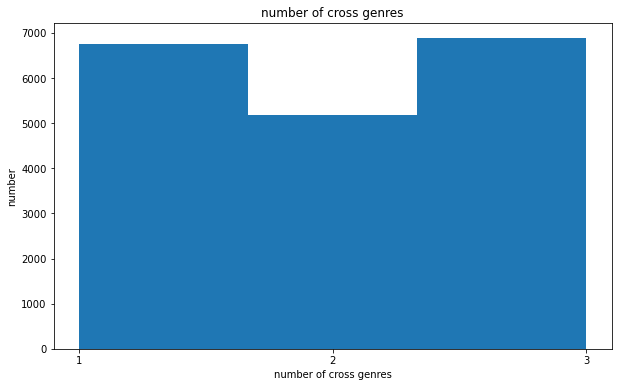

In [36]:
fig,ax = plt.subplots(figsize = (10,6))
ax.hist(df_genre['n of genres'].sort_values(),bins=3)
ax.set_title('number of cross genres')
ax.set_xlabel('number of cross genres')
ax.set_ylabel('number');

# 1/2/3 genres are similar

In [33]:
df_join_clean.groupby('IMDB_genres').count()

,primary_title,original_title_x,IMDB_ratings,IMDB_nvotes,release_date,vote_average,vote_count
IMDB_genres,,,,,,,
Action,150,150,150,150,150,150,150
"Action,Adventure",28,28,28,28,28,28,28
"Action,Adventure,Animation",53,53,53,53,53,53,53
"Action,Adventure,Biography",9,9,9,9,9,9,9
"Action,Adventure,Comedy",97,97,97,97,97,97,97
...,...,...,...,...,...,...,...
Thriller,492,492,492,492,492,492,492
"Thriller,War",2,2,2,2,2,2,2
"Thriller,Western",3,3,3,3,3,3,3


# MOVIE CHANGES THROUGH TIME

movie made every year, movie genre changes, budget changes, gross changes, etc.

In [37]:
df_join_clean

,primary_title,original_title_x,IMDB_genres,IMDB_ratings,IMDB_nvotes,release_date,vote_average,vote_count
0,#ALLMYMOVIES,#ALLMYMOVIES,Documentary,8.3,21,2015-11-12,9.0,4
1,#Captured,#Captured,Thriller,2.8,212,2017-10-11,3.2,6
2,#FollowFriday,#FollowFriday,Thriller,2.8,186,2016-07-01,3.2,7
3,#Horror,#Horror,"Crime,Drama,Horror",3.0,3092,2015-11-20,3.3,102
4,#Lucky Number,#Lucky Number,Comedy,5.1,425,2015-09-01,6.0,2
...,...,...,...,...,...,...,...,...
19874,i hate myself :),i hate myself :),"Comedy,Documentary,Drama",7.7,46,2013-07-19,8.0,1
19875,iGirlfriend,iGirlfriend,Comedy,2.7,200,2017-01-15,4.0,4
19876,iSteve,iSteve,"Biography,Comedy",5.3,1098,2013-04-14,4.8,22
19877,xXx: Return of Xander Cage,xXx: Return of Xander Cage,"Action,Adventure,Thriller",5.2,77976,2017-01-20,5.6,2452


In [38]:
# genre changes through years
# first, group by year

df_join_clean.loc[:,'Release_Year'] = pd.DatetimeIndex(df_join_clean.release_date).year

df_join_clean.head()

,primary_title,original_title_x,IMDB_genres,IMDB_ratings,IMDB_nvotes,release_date,vote_average,vote_count,Release_Year
0,#ALLMYMOVIES,#ALLMYMOVIES,Documentary,8.3,21,2015-11-12,9.0,4,2015
1,#Captured,#Captured,Thriller,2.8,212,2017-10-11,3.2,6,2017
2,#FollowFriday,#FollowFriday,Thriller,2.8,186,2016-07-01,3.2,7,2016
3,#Horror,#Horror,"Crime,Drama,Horror",3.0,3092,2015-11-20,3.3,102,2015
4,#Lucky Number,#Lucky Number,Comedy,5.1,425,2015-09-01,6.0,2,2015


In [39]:
df_join_clean.groupby(by='Release_Year')['Release_Year'].count()

Release_Year
1949       2
1964       3
1968       2
1976       1
1978       1
1985       1
1986       3
1988       2
1995       1
1997       1
2000       3
2003       1
2005       4
2006       1
2007       1
2008       2
2009      11
2010    1454
2011    1847
2012    1879
2013    2361
2014    2337
2015    2357
2016    2317
2017    2222
2018    1935
2019      81
Name: Release_Year, dtype: int64

Text(0.5, 1.0, 'number of movies made through the years')

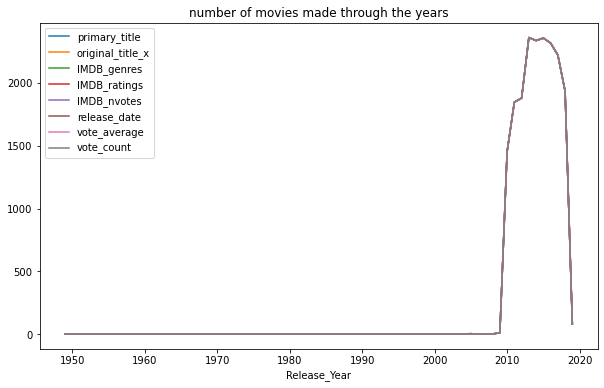

In [40]:
df_join_clean.groupby(by='Release_Year').count().plot(figsize=(10,6))

plt.title('number of movies made through the years')

# seems like making 2000+- movies each year
# the lower number in the early years, 
# maybe cause to no data tracking yet

In [41]:
# make a dictionary of unique genres
dict_genres = {key:0 for key in unique_genres}

for lst in df_genre['IMDB_genres']:
    for value in lst:
        if value in unique_genres:
            dict_genres[value] += 1
            
print(dict_genres)

{'Documentary': 3423, 'Thriller': 3483, 'Crime': 1739, 'Drama': 8635, 'Horror': 3227, 'Comedy': 4252, 'Romance': 1874, 'Adventure': 1336, 'Action': 2367, 'Sport': 364, 'News': 151, 'Music': 485, 'History': 639, 'Family': 827, 'Mystery': 1212, 'Biography': 1091, 'Sci-Fi': 1006, 'Fantasy': 702, 'Animation': 465, 'War': 227, 'Western': 123, 'Musical': 147, 'Reality-TV': 3, 'Adult': 1, 'Game-Show': 1}


In [42]:
df_genre_counts = pd.DataFrame.from_dict(dict_genres,orient='index',columns=['counts']).sort_values(by='counts')

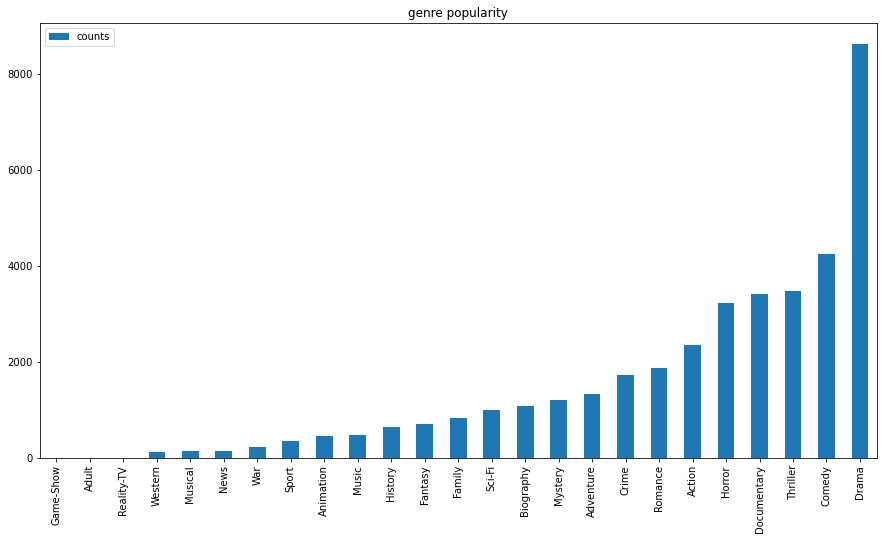

In [45]:
df_genre_counts.plot(kind='bar',figsize=(15,8))
plt.title('genre popularity');

# SOME ATTEMPTS

In [ ]:
# check the new df's rating

<AxesSubplot:>

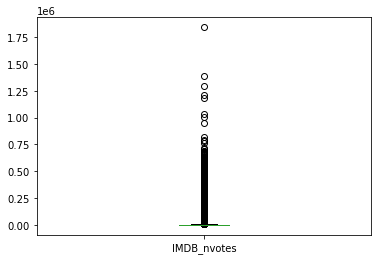

In [92]:
df_join_clean['IMDB_nvotes'].plot(kind='box')

In [ ]:
# different genres/genres combos' rating

In [101]:
df_join_clean.groupby(by='IMDB_genres')['IMDB_ratings'].mean()

IMDB_genres
Action                        5.206000
Action,Adventure              5.117857
Action,Adventure,Animation    6.592453
Action,Adventure,Biography    7.033333
Action,Adventure,Comedy       5.253608
                                ...   
Thriller                      5.118699
Thriller,War                  6.550000
Thriller,Western              6.900000
War                           5.360000
Western                       4.477419
Name: IMDB_ratings, Length: 617, dtype: float64

In [103]:
# top genres' rating
df_join_clean['IMDB_genres'].value_counts()

Drama                            2257
Documentary                      1709
Horror                            841
Comedy                            831
Comedy,Drama                      646
                                 ... 
Animation,Documentary,History       1
Documentary,News,War                1
Action,Thriller,Western             1
Drama,History,Mystery               1
Fantasy,Romance,Thriller            1
Name: IMDB_genres, Length: 617, dtype: int64

In [ ]:
first_20_genres = 

In [108]:
df_join_clean[df_join_clean['IMDB_genres']=='Drama'].IMDB_ratings.mean()

6.270536109880372

In [ ]:
# find the most popular genre and genre combos

In [109]:
first_100_genres = df_join_clean['IMDB_genres'].value_counts().head(100)

In [110]:
type(first_100_genres)

pandas.core.series.Series

In [ ]:
first_100_genres[:10].plot(kind='bar')

<AxesSubplot:>

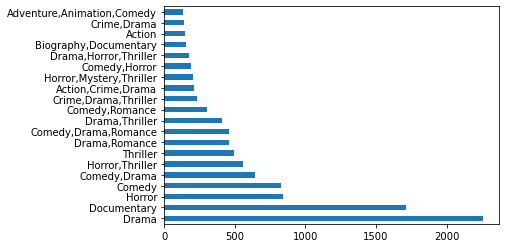

In [102]:
df_join_clean['IMDB_genres'].value_counts()[:20].plot(kind='barh')

In [ ]:
# find unique genres
# try find the ones without comma
# 21

individual_genre = df_join_clean[df_join_clean['IMDB_genres'].str.contains(',')==False]['IMDB_genres'].unique()

In [ ]:
df_game_movie = pd.read_csv('zippedData/List_of_highest-grossing_films_based_on_video_games_wikipedia.csv')

In [ ]:
df_game_movie_clean = df_game_movie[['Title','Based on video game(s)','Original game publisher(s)','Distributor','Format']]

In [ ]:
df_game_movie_clean.info()

In [ ]:
df_game_movie_clean['Format'].value_counts().plot(kind='barh')

In [ ]:
df_game_movie_clean.head(10)

In [ ]:
# combine BOM/TN with LIST of wikipedia game movie list

In [69]:
df_tn = pd.read_csv('zippedData/tn.movie_budgets.csv')

In [70]:
df_tn

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"
...,...,...,...,...,...,...
5777,78,"Dec 31, 2018",Red 11,"$7,000",$0,$0
5778,79,"Apr 2, 1999",Following,"$6,000","$48,482","$240,495"
5779,80,"Jul 13, 2005",Return to the Land of Wonders,"$5,000","$1,338","$1,338"
5780,81,"Sep 29, 2015",A Plague So Pleasant,"$1,400",$0,$0


In [ ]:
df_join_wiki_tn = pd.merge(df_game_movie_clean,df_tn,how='left',right_on='movie',left_on='Title')

In [ ]:
df_join_wiki_tn

In [ ]:
df_tn[df_tn['movie'].str.contains('Pikachu')]['movie']='Detective Pikachu'

In [ ]:
# find dataset on Kaggle
# https://www.kaggle.com/datasets/bcruise/film-adaptations-of-video-games

In [ ]:
df_kaggle_game = pd.read_csv('zippedData/video_game_films.csv')

In [ ]:
df_kaggle_game.head()

In [ ]:
df_kaggle_game['Release date'] = pd.to_datetime(df_kaggle_game['Release date'])

In [ ]:
df_kaggle_game['Release date'].value_counts()